## references 
https://data-flair.training/blogs/custom-object-detection-yolo/




# 1. Install and Import Dependencies


In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html


In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r /content/yolov5/requirements.txt


In [41]:
import os  
import cv2
import torch 
import matplotlib.pyplot as plt
import numpy as np


## change the yaml file to custimize it for your data || path /content/yolov5/data/

train :  /content/dataset/TrainImages

val :  /content/dataset/TestImages

nc : 1

names : ["sinature"]

# 2:Preparing the dataset

YOLO format dataset contains each image file with a text file of the same name. The text file contains the information about the annotations. The file contains each line for all the objects present in the image, if there are 3 objects then the file will contain 3 lines. Each line contains details about individual objects. The parameters or details are the class label for the object, the x and y position of the object, and the height and width of the object. [link text](https://github.com/ultralytics/yolov5/discussions/**2032**)
  - One row per object

  - Each row is class x_center y_center width height format.
  
  - Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
 
  - Class numbers are zero-indexed (start from 0).

## **Problems in our data set**

## 1:  IN OUR DATASET WE HAVE DIM OF TWO POINTS  INSTEAD OF ONE POINT , WIDTH AND HEIGHT SO WE HAVE TO CONVERT IT and **normalize the dim**  

## 2: txt files should be in the same folder of images but in our data they aren't 

#### the dataset are in my drive in zip format 

In [11]:
# clone the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -r /content/dataset
! unzip /content/drive/MyDrive/SignatureObjectDetection.zip -d /content/dataset

### solve the first problems change the content of text files to be x,y,w,h

In [13]:
# '509,639,864,694\n  sample of the line in txt file after reading it 
def convert_xy_to_xywh (img_path ,txt_content):

  img = cv2.imread(img_path)
  img_w , img_h ,_  = img.shape

  out = []
  for line in txt_content:

     x1,y1,x2,y2 = line.split(",")
     y2 =(y2)[:-1]  # to skip \n 

     x_center_normalized = ((int(x2) +  int (x1)) / 2 ) / img_w
     y_center_normalized = ((int(y2) +  int (y1)) / 2 ) / img_h

     w_normalized =  (int(x2) -  int (x1)) / img_w
     h_normalized =  (int(y2) -  int (y1)) / img_h

     out.append(f"{0} {x_center_normalized} {y_center_normalized} {w_normalized} {h_normalized}\n")

  #return  x_center_normalized,y_center_normalized,w_normalized,h_normalized 
  return out   

 


In [14]:
def data_preparing (path , label_path):

  files = os.listdir(label_path)
  files.sort()

  for file in files :
    img_path =  os.path.join( path , file.split(".")[0]+".tif" )

    txt_path = os.path.join(label_path,file)

    with open(txt_path , 'r') as file :
      data = file.readlines()

    with open (txt_path,'w') as file :
      #x_center, y_center, w, h = convert_xy_to_xywh(data)
      #file.writelines(f"{class_num} {x_center} {y_center} {w} {h} \n")  
      file.writelines(convert_xy_to_xywh(img_path , data))




In [15]:
# for train data 
img_path = "/content/dataset/TrainImages"
label_path = "/content/dataset/TrainGroundTruth"
data_preparing(img_path , label_path)

#for test data  
img_path = "/content/dataset/TestImages"
label_path = "/content/dataset/TestGroundTruth"
data_preparing(img_path , label_path)


In [16]:
!mv /content/dataset/TrainGroundTruth/*  /content/dataset/TrainImages/
!mv /content/dataset/TestGroundTruth/*   /content/dataset/TestImages/


# 3:  Custom yolo training 

In [18]:
!python /content/yolov5/train.py --img-size 640 --batch-size 16 --epochs 5 --data dataset.yaml --cfg /content/yolov5/models/yolov5s.yaml --weights yolov5s.pt


train: weights=yolov5s.pt, cfg=/content/yolov5/models/yolov5s.yaml, data=dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-133-gcca5e21 Python-3.9.16 torch-1.8.1+cu111 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, f

# 4: model evaluation 

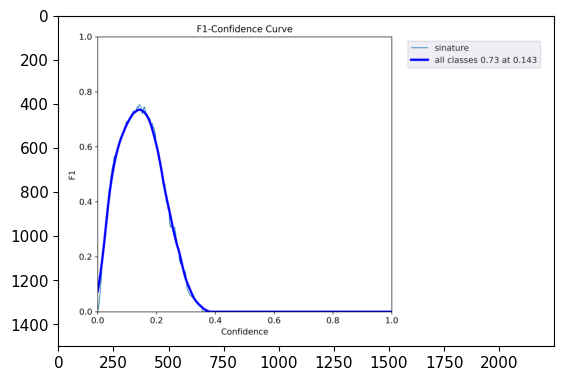

In [21]:
plt.imshow(plt.imread("/content/yolov5/runs/train/exp/F1_curve.png"))

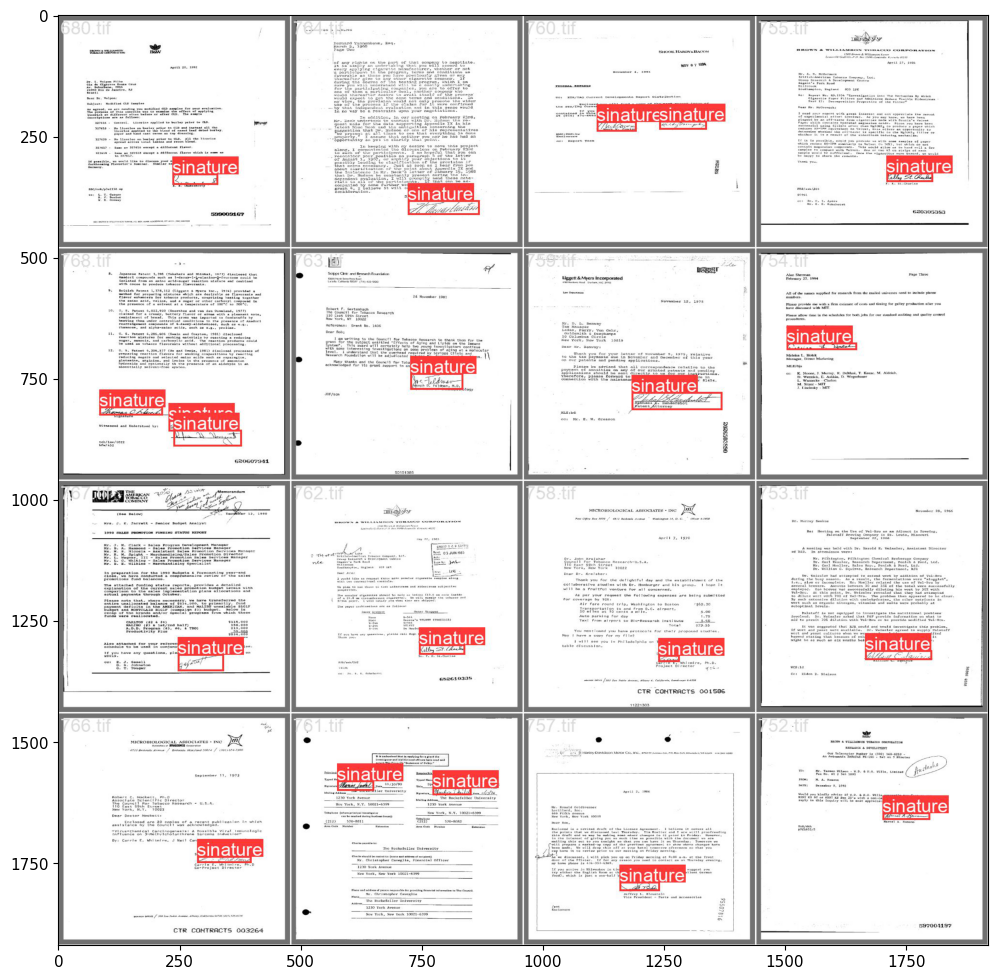

In [27]:
fig, ax = plt.subplots(figsize=(12, 15))
plt.imshow(plt.imread("/content/yolov5/runs/train/exp/val_batch0_labels.jpg"))

# final test your model 

In [30]:
# load the model  
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/exp/weights/last.pt', force_reload=True)



Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-4-2 Python-3.9.16 torch-1.8.1+cu111 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [38]:
img = "/content/drive/MyDrive/SignatureObjectDetection/TrainImages/103.tif"
results = model(img)


In [39]:
print(results)

image 1/1: 1000x1000 1 sinature
Speed: 329.0ms pre-process, 48.1ms inference, 6.0ms NMS per image at shape (1, 3, 640, 640)


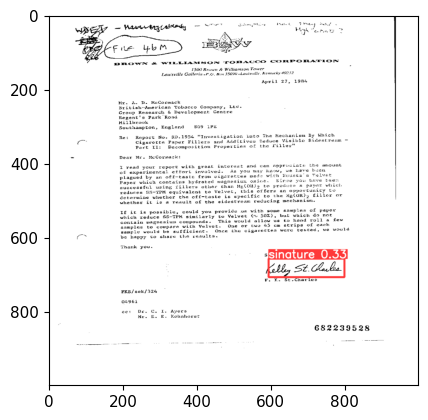

In [40]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(results.render()))
plt.show()